In [5]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, roc_curve, accuracy_score
from imblearn.metrics import specificity_score
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

# machine learning model
from sklearn.model_selection import (train_test_split, StratifiedShuffleSplit, cross_val_score)
import lightgbm as lgb
from imblearn.over_sampling import SMOTE


# oversampling
from imblearn.over_sampling import SVMSMOTE

# hyperparameter tuning
import optuna
import joblib

In [2]:
# load data
df = pd.read_excel("../data/raw/Telco_customer_churn_adapted_v2.xlsx")
df_ori = df.copy()

In [3]:
# function for feature engineering
def check_internet_service(row): 
    if row['Games Product'] == "No internet service"\
        and row['Music Product'] == "No internet service"\
        and row['Education Product'] == "No internet service"\
        and row['Video Product'] == "No internet service"\
        and row['Use MyApp'] == "No internet service":
        return 0
    else: return 1

def uses_internet_for_product(data):
    if data == "Yes": 
        return 1
    return 0

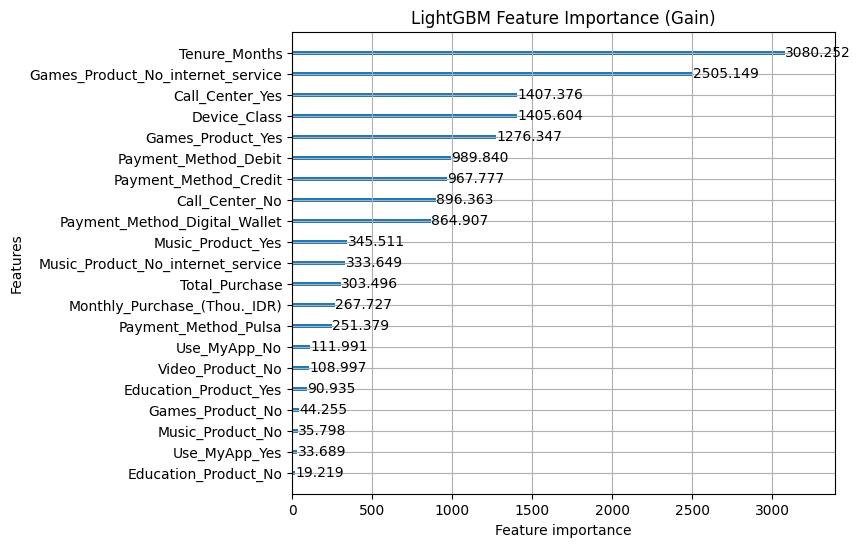

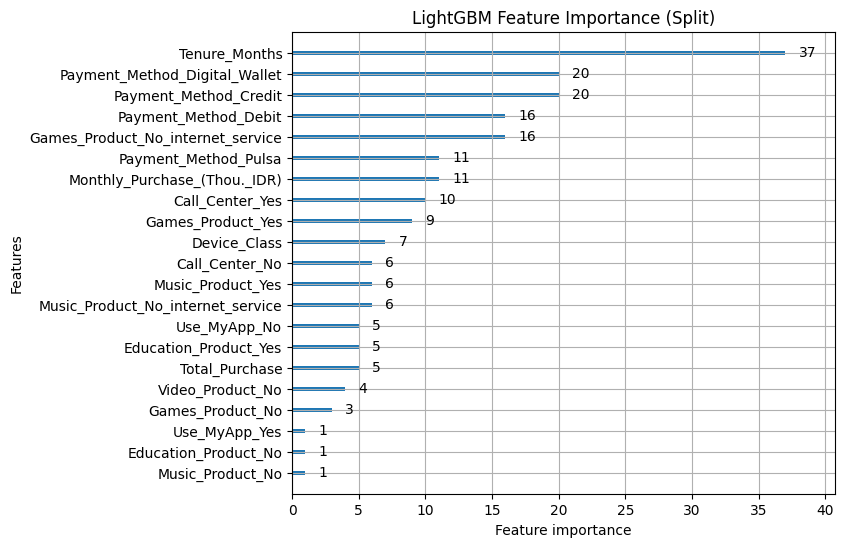

In [7]:
def data_preparation(data):
    # Data Preparation
    # ==============================================
    
    df = data.copy()
    # feature engineering
    df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)
    df["Total Purchase"] = df["Tenure Months"] * df["Monthly Purchase (Thou. IDR)"]

    # encoding
    df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})
    df["Churn Label"] = df["Churn Label"].replace({"Yes": 1, "No": 0})
    
    df = df.drop(columns=["Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)"])  # drop unimportant data
    X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
    X_test[["Customer ID"]].to_csv("../data/processed/test_data_id.csv", index=False)
    X_train = X_train.drop(columns=["Customer ID"])
    X_test = X_test.drop(columns=["Customer ID"])

    # Oversampling for balancing dataset
    # ==============================================
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Scale data (tree model don't need for scaling)
    # ==============================================
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)  # <<<<<<<<<<<<< SCALING
    X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)  # <<<<<<<<<<<<< SCALING
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = data_preparation(df_ori)
    
model = joblib.load("../models/lgb.pkl")

# Plot feature importance using Gain
lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

# Plot feature importance using Gain
lgb.plot_importance(model, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()

In [11]:
model

LGBMClassifier(bagging_fraction=0.5596132124188054, bagging_freq=5,
               feature_fraction=0.6399218735601468,
               lambda_l1=0.0008760097739004018, lambda_l2=0.3476902177667727,
               min_child_samples=100, num_leaves=3, random_state=42)

In [10]:
lgb.create_tree_digraph(model)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

# Extra: Retention Strategy

[LightGBM] [Warning] feature_fraction is set=0.4386219301785611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4386219301785611
[LightGBM] [Warning] lambda_l1 is set=4.9087660802805254e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.9087660802805254e-08
[LightGBM] [Warning] lambda_l2 is set=7.107814046559069e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.107814046559069e-08
[LightGBM] [Warning] bagging_fraction is set=0.5853318649736283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5853318649736283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


<Axes: >

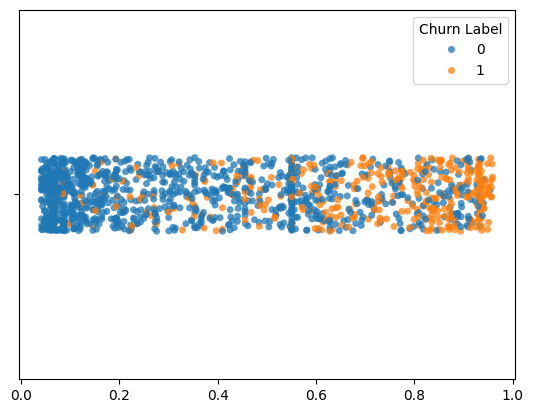

In [27]:
y_pred_proba = model.predict_proba(X_test)
sns.stripplot(x=y_pred_proba[:, 1], hue=y_test, alpha=0.75)

[LightGBM] [Warning] feature_fraction is set=0.6399218735601468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6399218735601468
[LightGBM] [Warning] lambda_l1 is set=0.0008760097739004018, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008760097739004018
[LightGBM] [Warning] lambda_l2 is set=0.3476902177667727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3476902177667727
[LightGBM] [Warning] bagging_fraction is set=0.5596132124188054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5596132124188054
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


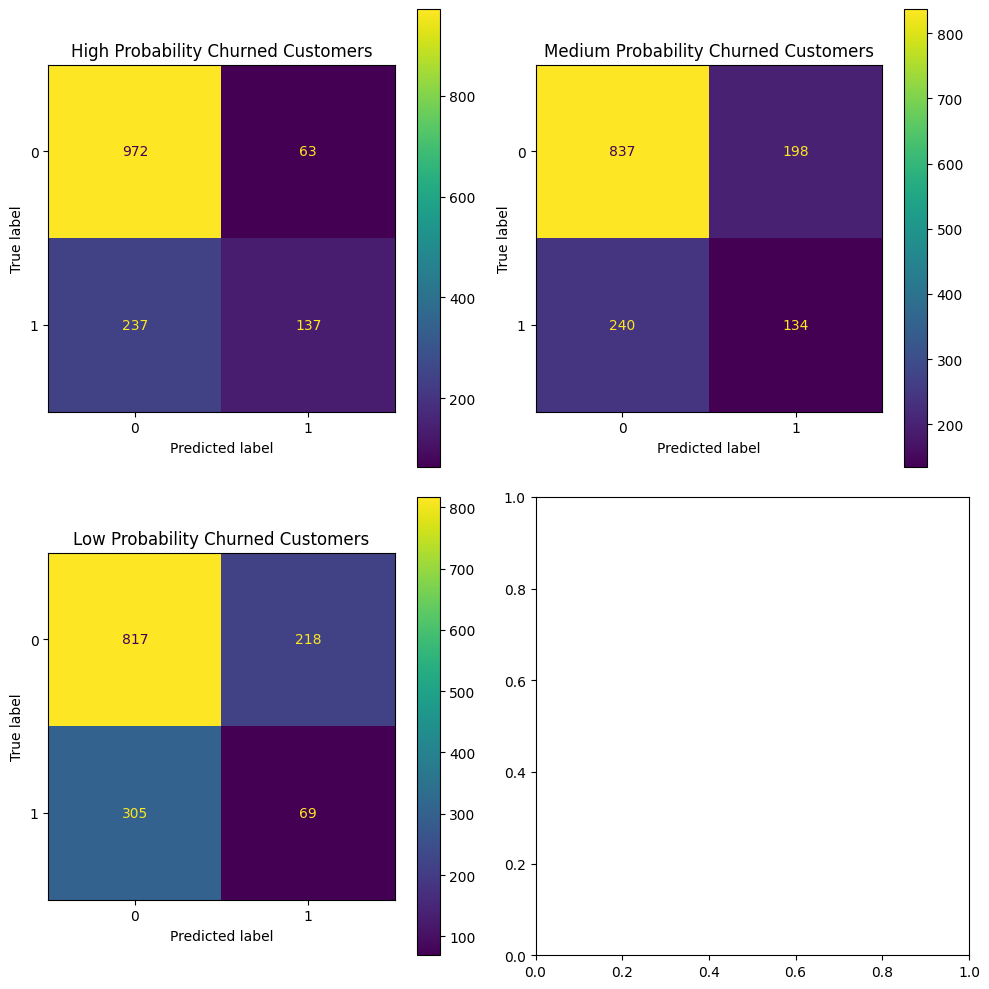

In [8]:
# confusion matrix
y_pred_proba = model.predict_proba(X_test)


fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))

y_pred_75 = [1 if p >= 0.75 else 0 for p in y_pred_proba[:, 1]] 
cm = confusion_matrix(y_test, y_pred_75, labels=model.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot(ax=ax[0][0])
ax[0][0].set_title("High Probability Churned Customers")

y_pred_50_75 = [1 if p >= 0.5 and p < 0.75 else 0 for p in y_pred_proba[:, 1]] 
cm = confusion_matrix(y_test, y_pred_50_75, labels=model.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot(ax=ax[0][1])
ax[0][1].set_title("Medium Probability Churned Customers")

y_pred_25_50 = [1 if p >= 0.25 and p < 0.5 else 0 for p in y_pred_proba[:, 1]] 
cm = confusion_matrix(y_test, y_pred_25_50, labels=model.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot(ax=ax[1][0])
ax[1][0].set_title("Low Probability Churned Customers")
fig.tight_layout()
plt.show()